# Obtain all necessary imports

In [1]:
from IPython import get_ipython;   
import numpy as np
import random
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from numpy import dot, multiply, diag, power
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from matplotlib import animation
from IPython.display import display, HTML

In [2]:
# Add path to the save folder on this system
# Add path to the save folder on this system
if os.name == 'nt':  # Windows
    folder_path = r'C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data'
    sim_folder_path = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data\simulationResults\Supplement"
else:  # macOS/Linux
    folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data'
    sim_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/simulationResults/Mayesha0512'


# Create the pouch class and pouch operations

In [3]:
class Pouch(object): 
    def __init__(self, params=None, size = 'small', sim_number=0, save=False, saveName='default'):
        
        """Class implementing pouch structure and simulating Calcium signaling.
        Inputs:
        
        params (dict)
            A Python dictionary of parameters to simulate with the keys:
            ['K_PLC', 'K_5', 'k_1' , 'k_a', 'k_p', 'k_2', 'V_SERCA', 'K_SERCA', 'c_tot', 'beta', 'k_i', 'D_p', 'tau_max', 'k_tau', 'lower', 'upper','frac', 'D_c_ratio']
        
        size (string)
            Size of the pouch to simulate:
            [xsmall, small, medium, or large]
        
        sim_number (integer)
            Represents ID of a simulation to save the figures with unique names and set the random number generator seed
        
        save (boolean)
            If True, the simulation outputs will be saved
        
        saveName (string)
            Additional distinct name to save the output files as
        
        """
        # Create characteristics of the pouch object
        self.size=size
        self.saveName=saveName
        self.sim_number=sim_number
        self.save=save
        self.param_dict=params
        
        # If parameters are not set, then use baseline values
        if self.param_dict==None:
            self.param_dict={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.5, 'upper':0.7, 'frac':0.007680491551459293, 'D_c_ratio':0.1,
            'alpha':0.025, 'Imax': 1, 'g_vgcc': 0.1, 'Ca_ext': 150, 'K_opt': 0.1, 'sim_time': 3600} 
        # If a dictionary is given, assure all parameters are provided
        required_params = ['D_c_ratio', 'D_p', 'K_5', 'K_PLC', 'K_SERCA', 'V_SERCA', 'beta', 'c_tot', 'frac', 
                   'k_1', 'k_2', 'k_a', 'k_i', 'k_p', 'k_tau', 'lower', 'tau_max', 'upper', 'alpha', 'Imax',
                   'sim_time']
        missing_params = [param for param in required_params if param not in self.param_dict]
        if missing_params:
            print(f"Improper parameter input, missing parameters: {missing_params}")
            return
            
        # Load statics for wing disc geometries    
        disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
        disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
        disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix
        
        self.adj_matrix=disc_adjs[self.size] # Adjacency Matrix
        self.laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
        self.new_vertices=disc_vertices[size] # Vertices
        
        # Establish baseline parameter values for the simulation
        self.K_PLC=self.param_dict['K_PLC']  # .2
        self.K_5=self.param_dict['K_5'] # 0.66
        self.k_1=self.param_dict['k_1'] # 1.11
        self.k_a=self.param_dict['k_a'] # 0.08
        self.k_p=self.param_dict['k_p'] # 0.13
        self.k_2=self.param_dict['k_2'] # 0.0203
        self.V_SERCA=self.param_dict['V_SERCA'] # .9
        self.K_SERCA=self.param_dict['K_SERCA'] # .1
        self.c_tot=self.param_dict['c_tot'] # 2
        self.beta=self.param_dict['beta'] # .185
        self.k_i=self.param_dict['k_i'] # 0.4
        self.D_p =self.param_dict['D_p'] # 0.005
        self.D_c =self.param_dict['D_c_ratio']*self.D_p
        self.tau_max=self.param_dict['tau_max'] # 800
        self.k_tau=self.param_dict['k_tau'] # 1.5
        self.lower=self.param_dict['lower'] # Lower bound of standby cell VPLCs
        self.upper=self.param_dict['upper'] # Upper bound of standy cell VPLCs
        self.frac=self.param_dict['frac']   # Fraction of initiator cells
        self.alpha = self.param_dict['alpha'] # 0.005
        self.Imax = self.param_dict['Imax'] # 1
        self.sim_time = self.param_dict['sim_time'] # 3600 seconds (1 hour)


        # Establish characteristics of the pouch for simulations
        self.n_cells=self.adj_matrix.shape[0] # Number of cells in the pouch
        self.dt=.2 # Time step for ODE approximations
        self.T=int(self.sim_time/self.dt) # Simulation to run for 3600 seconds (1 hour) by default



        self.disc_dynamics=np.zeros((self.n_cells,4,self.T)) # Initialize disc_dynamics to save simulation calcium, IP3, calcium_ER, ratio
        self.VPLC_state=np.zeros((self.n_cells,1)) # Initialize VPLC array for cells
    
    def simulate(self): # Simulate dynamics of system
            np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)
            
            self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
            self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
            self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
            stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
            self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
            
            V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
            
            # ODE approximation solving
            for step in range(1,self.T):
                # ARRAY REFORMATTING
                ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
                ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
                s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
                r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
                ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
                ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
                
                # ODE EQUATIONS
                self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2))).T
                self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
                self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
                self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

            
    def simulate_optogenetic_dt(self): # Simulate dynamics of system
        np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)

        # Optogenetic stimulation parameters
         # Time setup
        
        time_vector = np.arange(0, self.sim_time, self.dt)
        self.T = len(time_vector)  # Ensure simulation steps match

        # Optogenetic stimulus setup, always on by default
        cycle_duration = 120     # Full cycle (on + off)
        on_duration = 120        # Stimulation ON time
        off_duration = cycle_duration - on_duration

        opto_stimulation = np.zeros_like(time_vector)
        for i, t in enumerate(time_vector):
            if (t % cycle_duration) < on_duration:
                opto_stimulation[i] = self.alpha*self.Imax*1.0  # Stimulus is ON

        # Expand opto signal to all cells (shape: n_cells x T)
        opto_stimulation_matrix = np.tile(opto_stimulation, (self.n_cells, 1))


        
        self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
        self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
        self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
        stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
        self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
        
        V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
        # ODE approximation solving
        for step in range(1,self.T):
            # ARRAY REFORMATTING
            ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
            ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
            s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
            r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
            ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
            ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)

            # Add optogenetic stimulus to calcium term
            opto_term = opto_stimulation_matrix[:, step].reshape(-1, 1)

            opto_term_dt = opto_term * self.dt
            opto_term_dt = np.minimum(opto_term_dt, 5)  # Apply maximum limit for calcium
            # ODE EQUATIONS
            self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2)) + opto_term_dt).T
            self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
            self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
            self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

    def make_animation(self, path=sim_folder_path): # Creation of calcium video
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(np.max(self.disc_dynamics[:,0,:]),1))
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(25,15))
                fig.patch.set_alpha(0.)
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
                patches = [matplotlib.patches.Polygon(verts) for verts in self.new_vertices ]
                def time_stamp_gen(n):
                    j=0
                    while j < n: # 0.2 sec interval to 1 hour time lapse
                        yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*self.dt , 60))
                        j+= 50
                time_stamps=time_stamp_gen(self.T)
                def init():
                    return [ax.add_patch(p) for p in patches]

                def animate(frame,time_stamps):
                    for j in range(len(patches)):
                        c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                        patches[j].set_facecolor(c)
                    ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                    return patches

                anim = animation.FuncAnimation(fig, animate, 
                                               init_func=init, 
                                               frames=self.disc_dynamics[:,0,::50].T, # Disc dynamics: Array of: [n cells x 4 x time-samples]
                                               fargs=(time_stamps,),
                                               interval=70,
                                               blit=True)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                anim.save(path+"/"+self.size+'Disc_'+str(self.sim_number)+'_'+self.saveName+'.mp4')
            else:
                print("Provide a path for saving videos")
        
    def draw_profile(self, path=sim_folder_path): # Draw the VPLC Profile for the simulation
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=.0, vmax=1.5)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='black')
                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(self.VPLC_state[k]))[0], keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".svg",transparent=True, bbox_inches="tight")
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

    def draw_profile_ca2(self, path=sim_folder_path): # Draw the max calcium concentration profile for the simulation
        # Making the color map inverted green
        colormap = plt.cm.Greens_r
        normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
        with sns.axes_style("white"):
                fig = plt.figure(figsize=(45, 25))
                ax = fig.add_subplot(1, 1, 1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar = fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80, fontweight="bold")
                # Set colorbar label
                cbar.set_label('Max Calcium Concentration', fontsize=80, fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:, 0], cell[:, 1], linewidth=1.0, color='black')
                max_calcium = np.max(self.disc_dynamics[:, 0, :], axis=1)  # Calculate max calcium concentration for each cell
                for k in range(len(self.new_vertices)):
                        cell = self.new_vertices[k]
                        c = colors.to_hex(colormap(normalize(max_calcium[k])), keep_alpha=False)
                        ax.fill(cell[:, 0], cell[:, 1], c)
        if self.save:
            if path is not None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path + "/" + self.size + 'Disc_MaxCalciumProfile_' + str(self.sim_number) + '_' + self.saveName + ".svg", transparent=True, bbox_inches="tight")
                fig.savefig(path + "/" + self.size + 'Disc_MaxCalciumProfile_' + str(self.sim_number) + '_' + self.saveName + ".png", transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

    def draw_kymograph(self, path=sim_folder_path): # Draw the calcium Kymograph for the simulation
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                x_center, y_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
            y_axis=centeriods[:,1]
            kymograp_index=np.where((y_axis<(-490)) & (y_axis>(-510))) # Location of where to draw the kymograph line

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(30,10))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.yticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.xticks([])
            plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsmall':
                plt.xlabel('Position',fontsize=20,fontweight='bold')
            else:
                plt.xlabel('Position',fontsize=30,fontweight='bold')
            
            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.size+'Disc_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph

    def count_spiking_cells(self, threshold=0.5, path=sim_folder_path):
        """
        Count the number of cells that spike above a calcium threshold in this simulation.

        Parameters:
            threshold: float, the calcium concentration threshold for spiking.

        Returns:
            int: The number of cells that spike above the threshold.
        """
        return int(np.sum(np.max(self.disc_dynamics[:, 0, :], axis=1) > threshold))
    

# Establish simulation parameters to replicate four calcium patterns
### NOTE:
All wings are 'large' wings where the only difference in simulation parameters is the increasing range of $V_{PLC}$ values for standby cells. Initiator cells are the same for each simulation, which is determined by the same random number generator seed.

In [4]:
# Get cell count from Pouch and make fraction of initiator cells
p_ex = Pouch(size='small', sim_number=0, save=False)
n_cells=p_ex.n_cells
frac = 1/(n_cells)**0.8
print(f'Number of cells: {n_cells}')
print(f"Fraction of initiator cells: {frac}")


Number of cells: 860
Fraction of initiator cells: 0.004491601715197952


In [5]:
sim_params_Spikes = {
    'K_PLC': 0.2, 'K_5': 0.66, 'k_1': 1.11, 'k_a': 0.08, 'k_p': 0.13, 'k_2': 0.0203, 'V_SERCA': 0.9, 'K_SERCA': 0.1,
    'c_tot': 2, 'beta': .185, 'k_i': 0.4, 'D_p': 0, 'tau_max': 800, 'k_tau': 1.5, 'lower': 0.2, 'upper': 0.4, 'frac': frac, 'D_c_ratio': 0.1,
    'alpha': 0.025, 'Imax': 1, 'sim_time': 3600, 
}  # Parameters for the Spikes simulation

saveFolderName = sim_folder_path  # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName):  # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)

In [6]:
# Make optogenetic stimulation simulations
# Create the Pouch objects for the optogenetic stimulation simulations
p_Spikes_opt_dt=Pouch(params=sim_params_Spikes, size='small', sim_number=12345, save=True, saveName='Fig_2_Spikes_opt_dt')
# Do simulations with the optogenetic stimulation
p_Spikes_opt_dt.simulate_optogenetic_dt()


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_83718/2278091111.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )


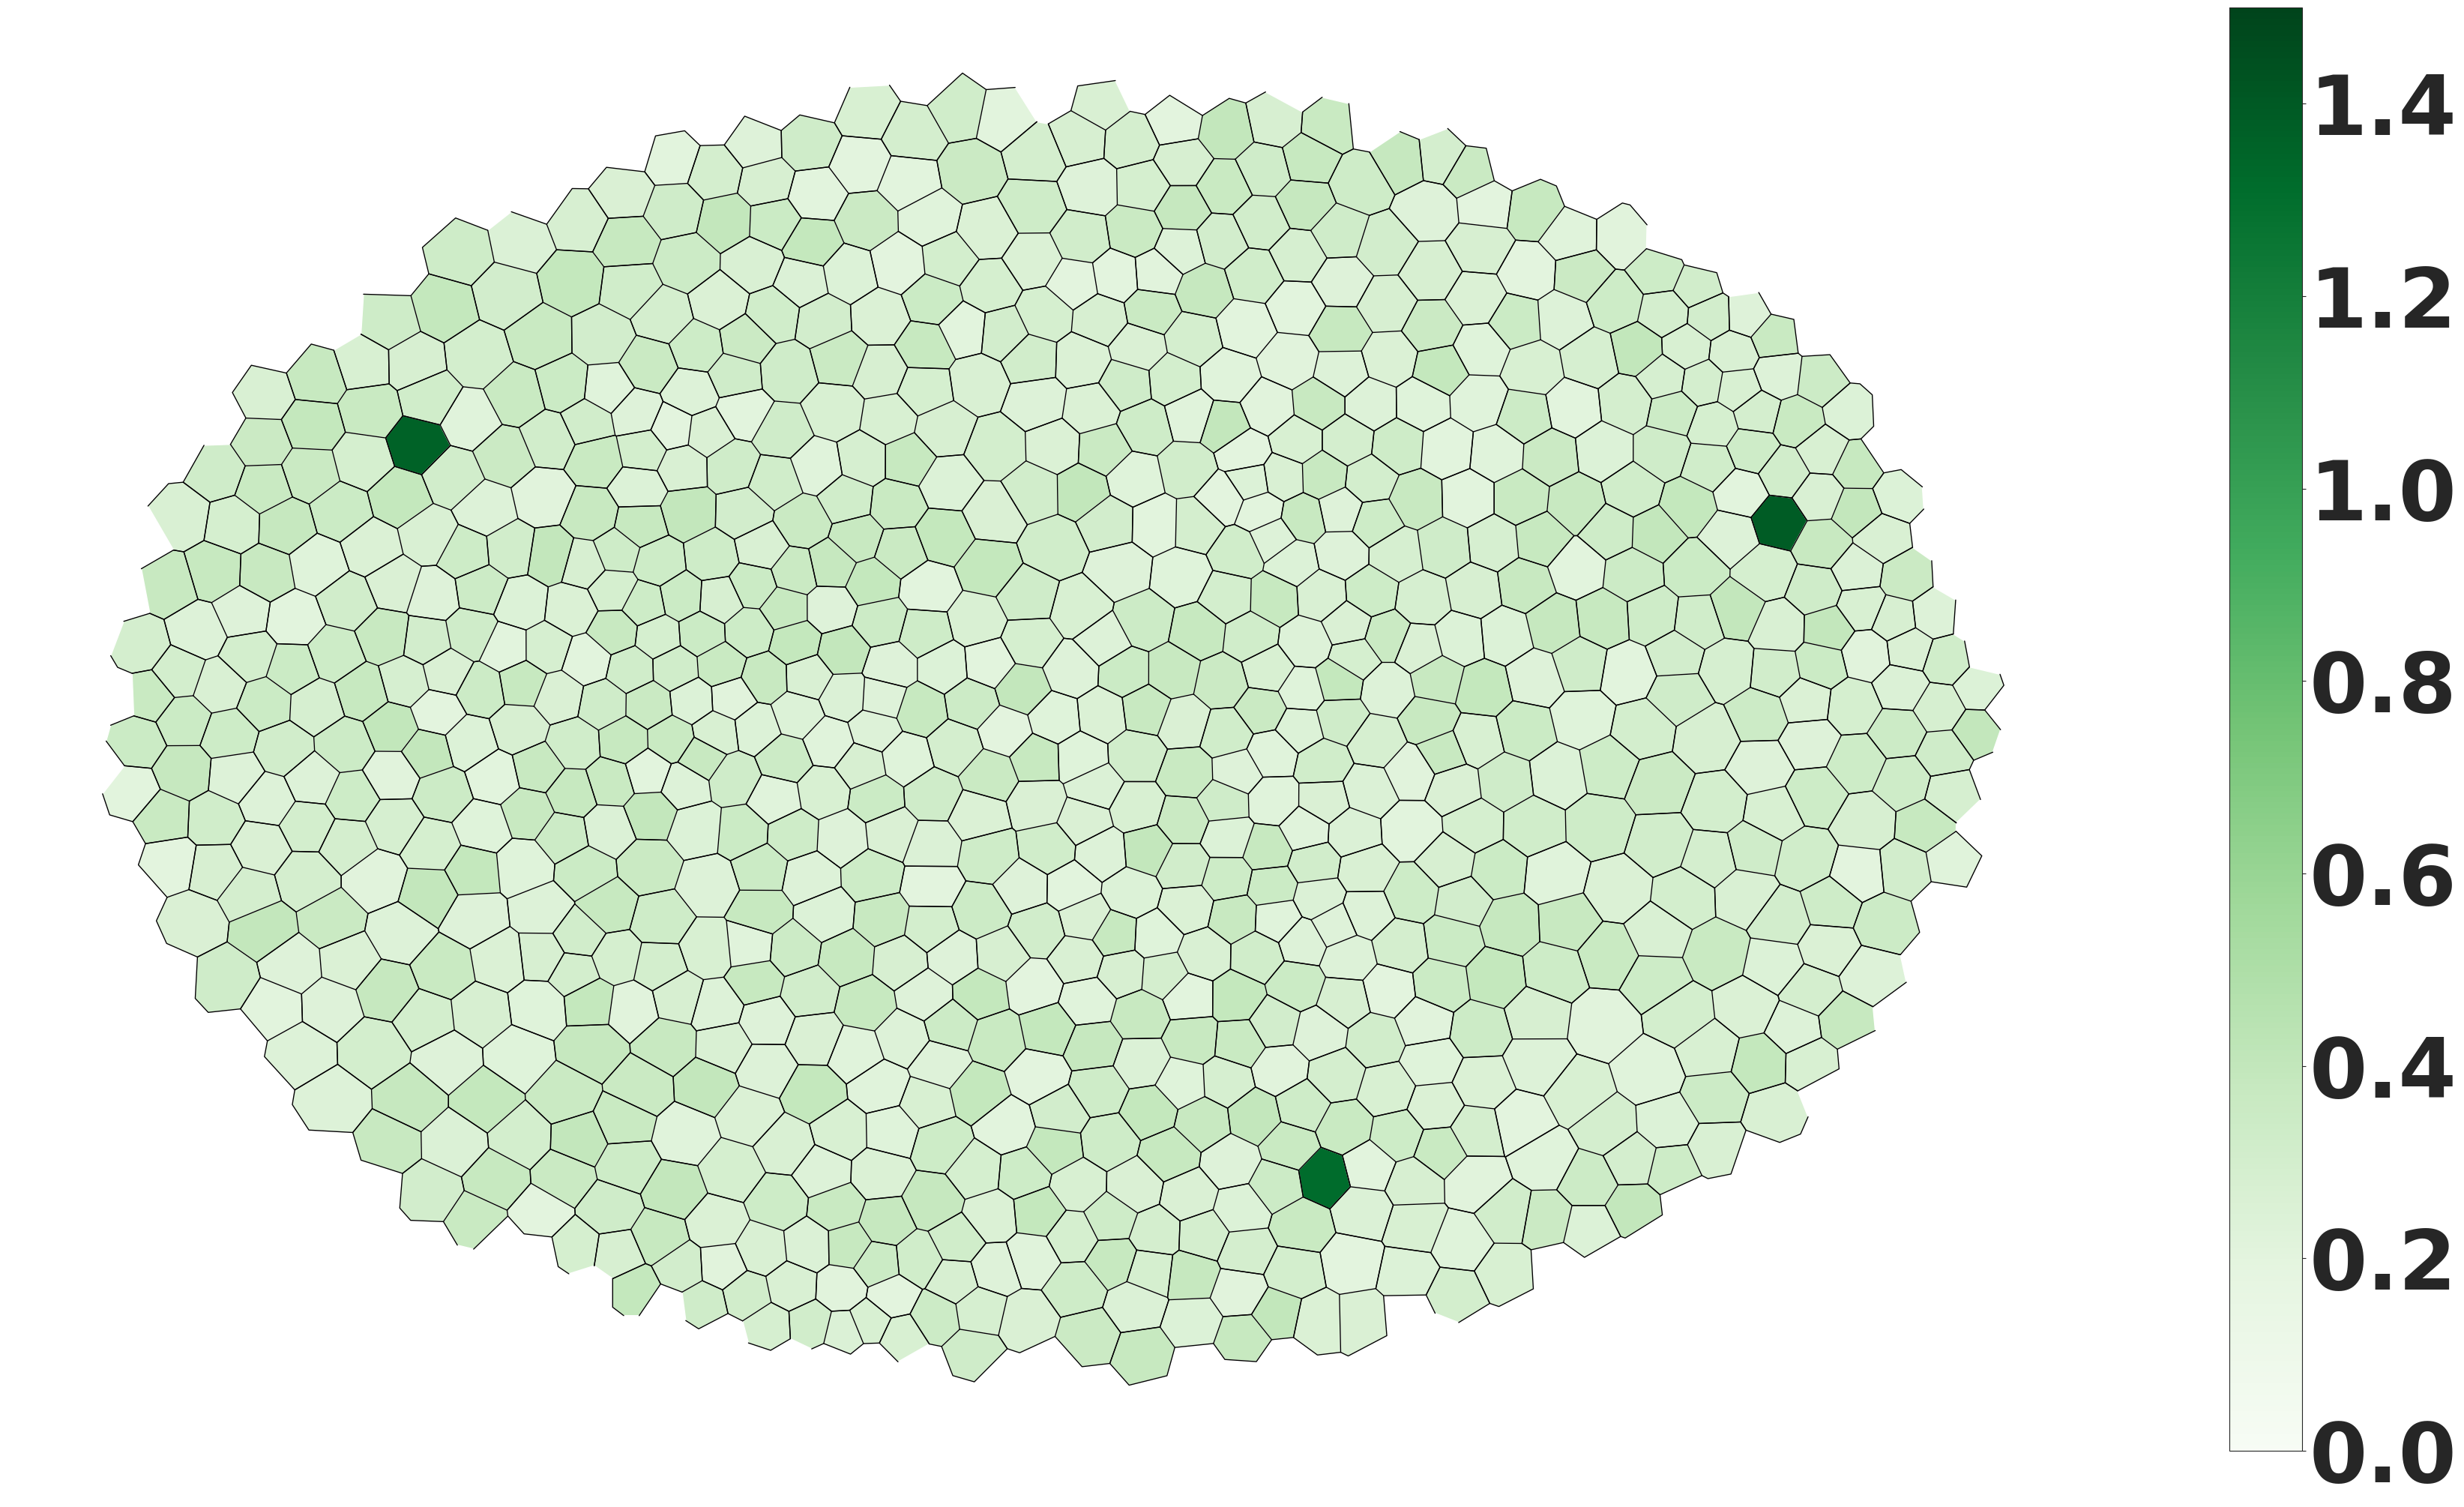

In [7]:
# Draw the VPLC profile for the simulation
p_Spikes_opt_dt.draw_profile(path=saveFolderName)

In [8]:
# Define the alpha values for the simulations
alpha_values = [0, 0.14 ]  # Different alpha values for testing

# Run simulations for each alpha value and store the results
simulations = {'Spikes': []}
for alpha in alpha_values:
    sim_params = sim_params_Spikes.copy()
    sim_params['alpha'] = alpha
    sim = Pouch(params=sim_params, size='small', sim_number=12345, save=False, saveName=f'Spikes_alpha_{alpha}_dt')
    sim.simulate_optogenetic_dt()
    sim.count_spiking_cells()  # Count the number of spiking cells
    print(f"Alpha: {alpha}, Spiking cells: {sim.count_spiking_cells()}, Spiking cell index: {np.where(np.max(sim.disc_dynamics[:, 0, :], axis=1) > 0.5)[0]}")
    simulations['Spikes'].append(sim)


Alpha: 0, Spiking cells: 3, Spiking cell index: [ 82 596 809]
Alpha: 0.14, Spiking cells: 21, Spiking cell index: [ 27  66  77  82 134 191 206 233 300 404 446 522 539 556 596 749 752 790
 809 834 858]


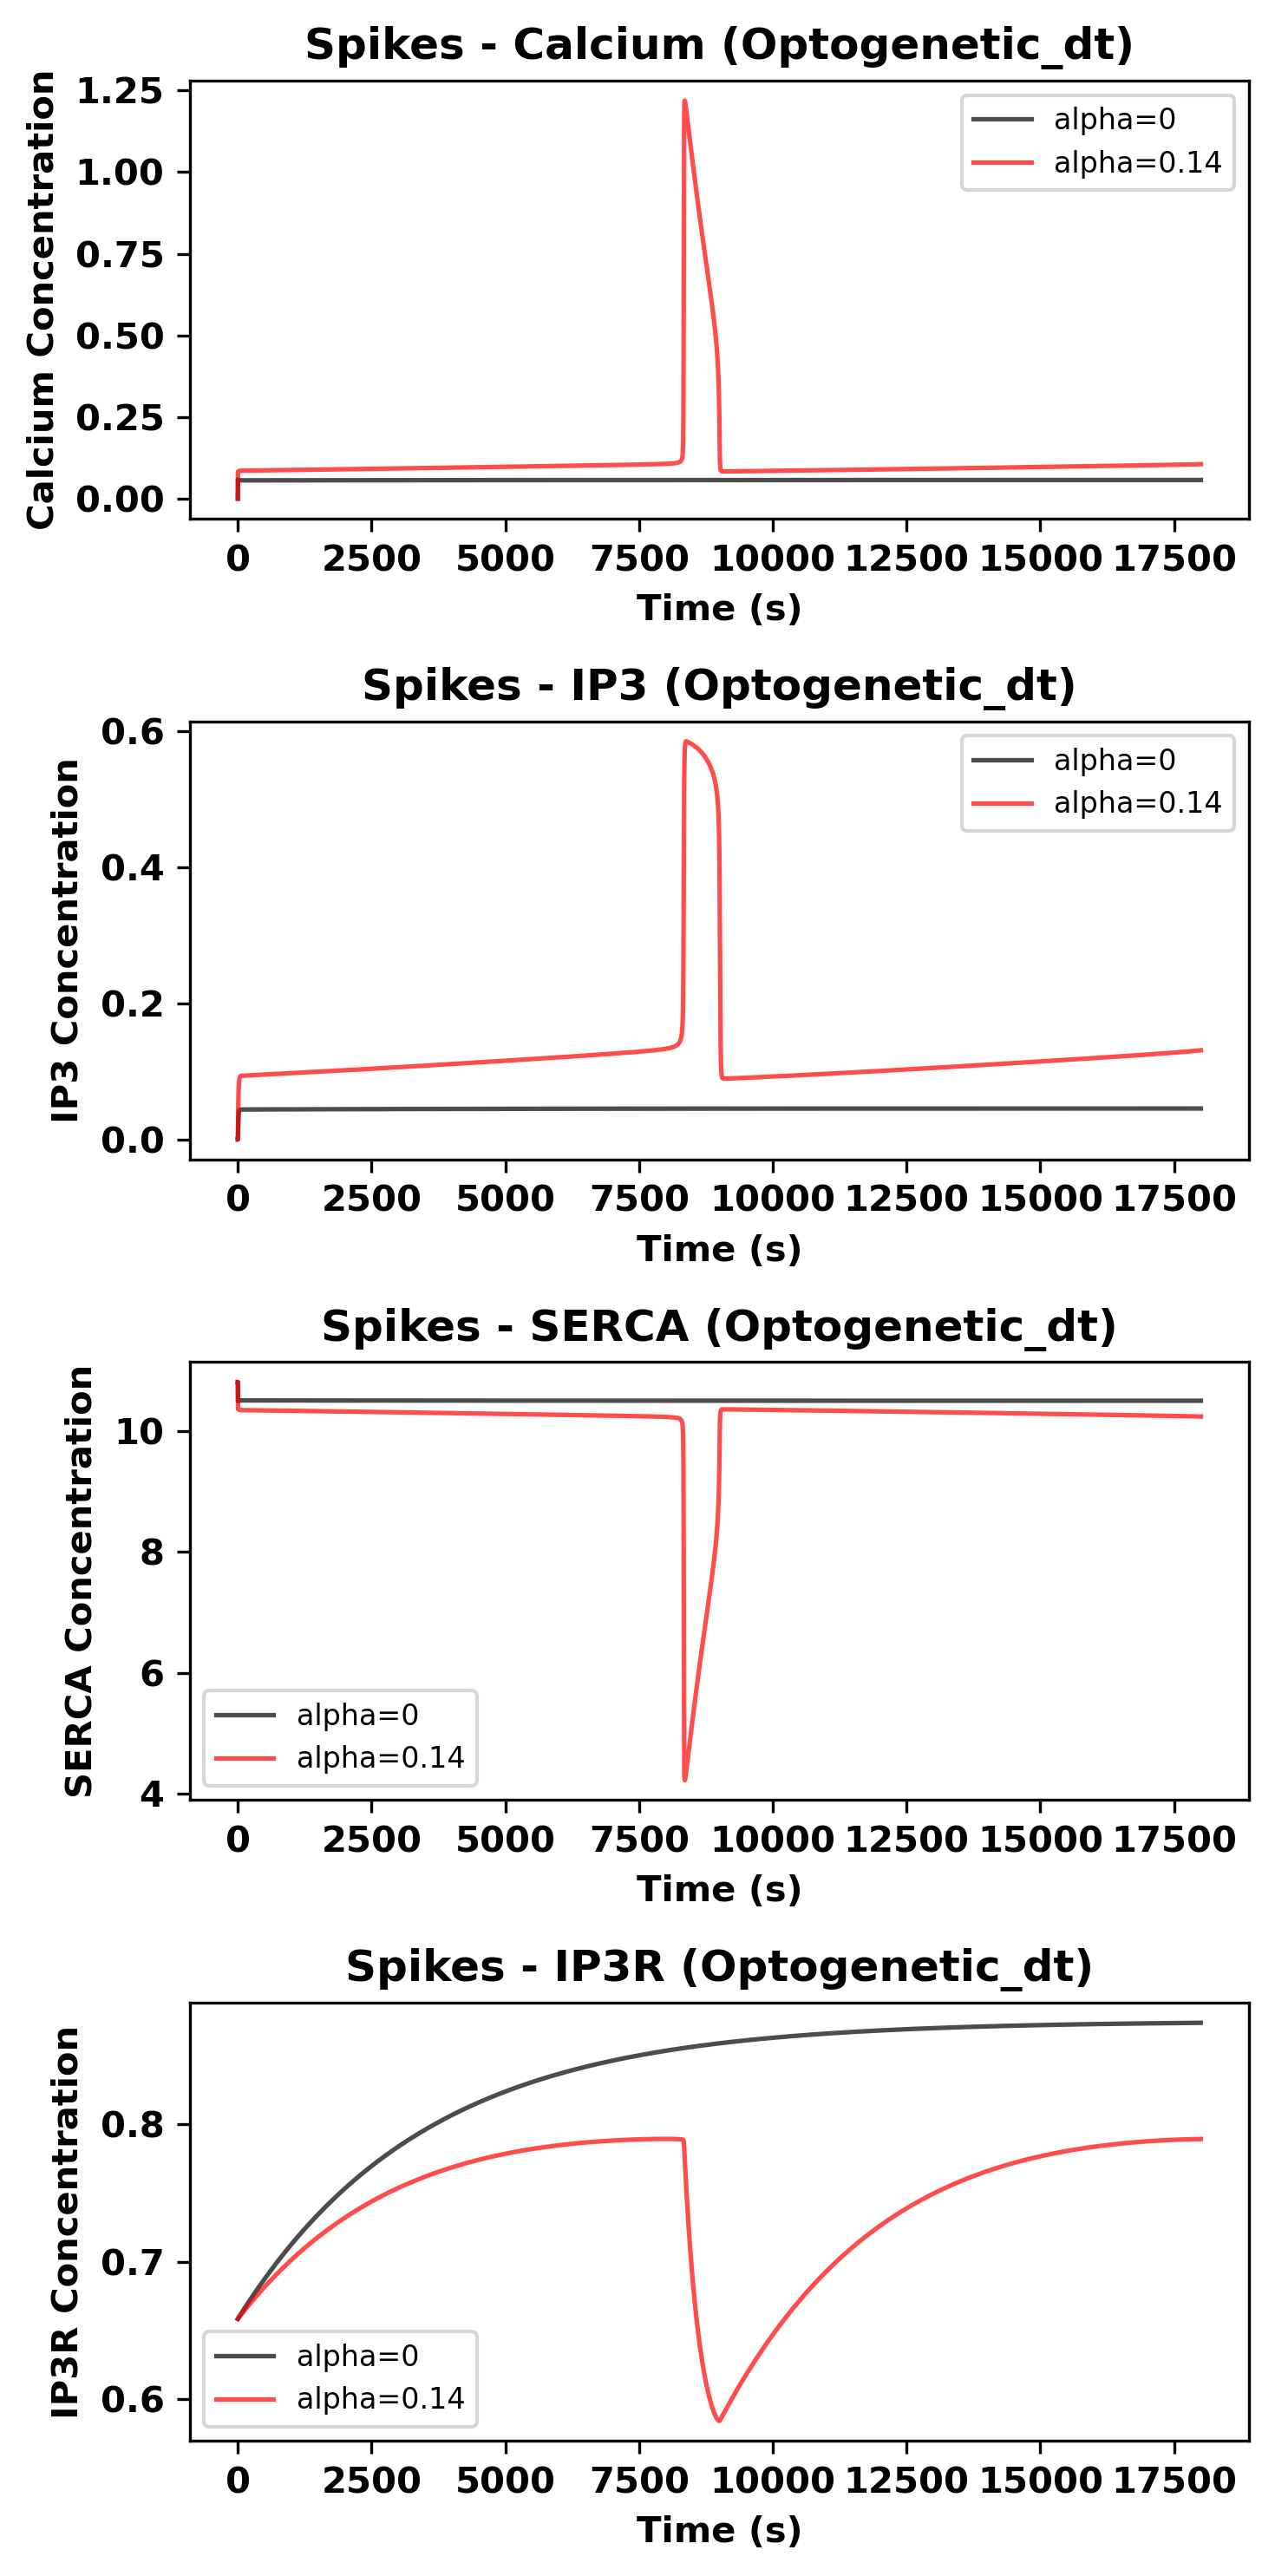

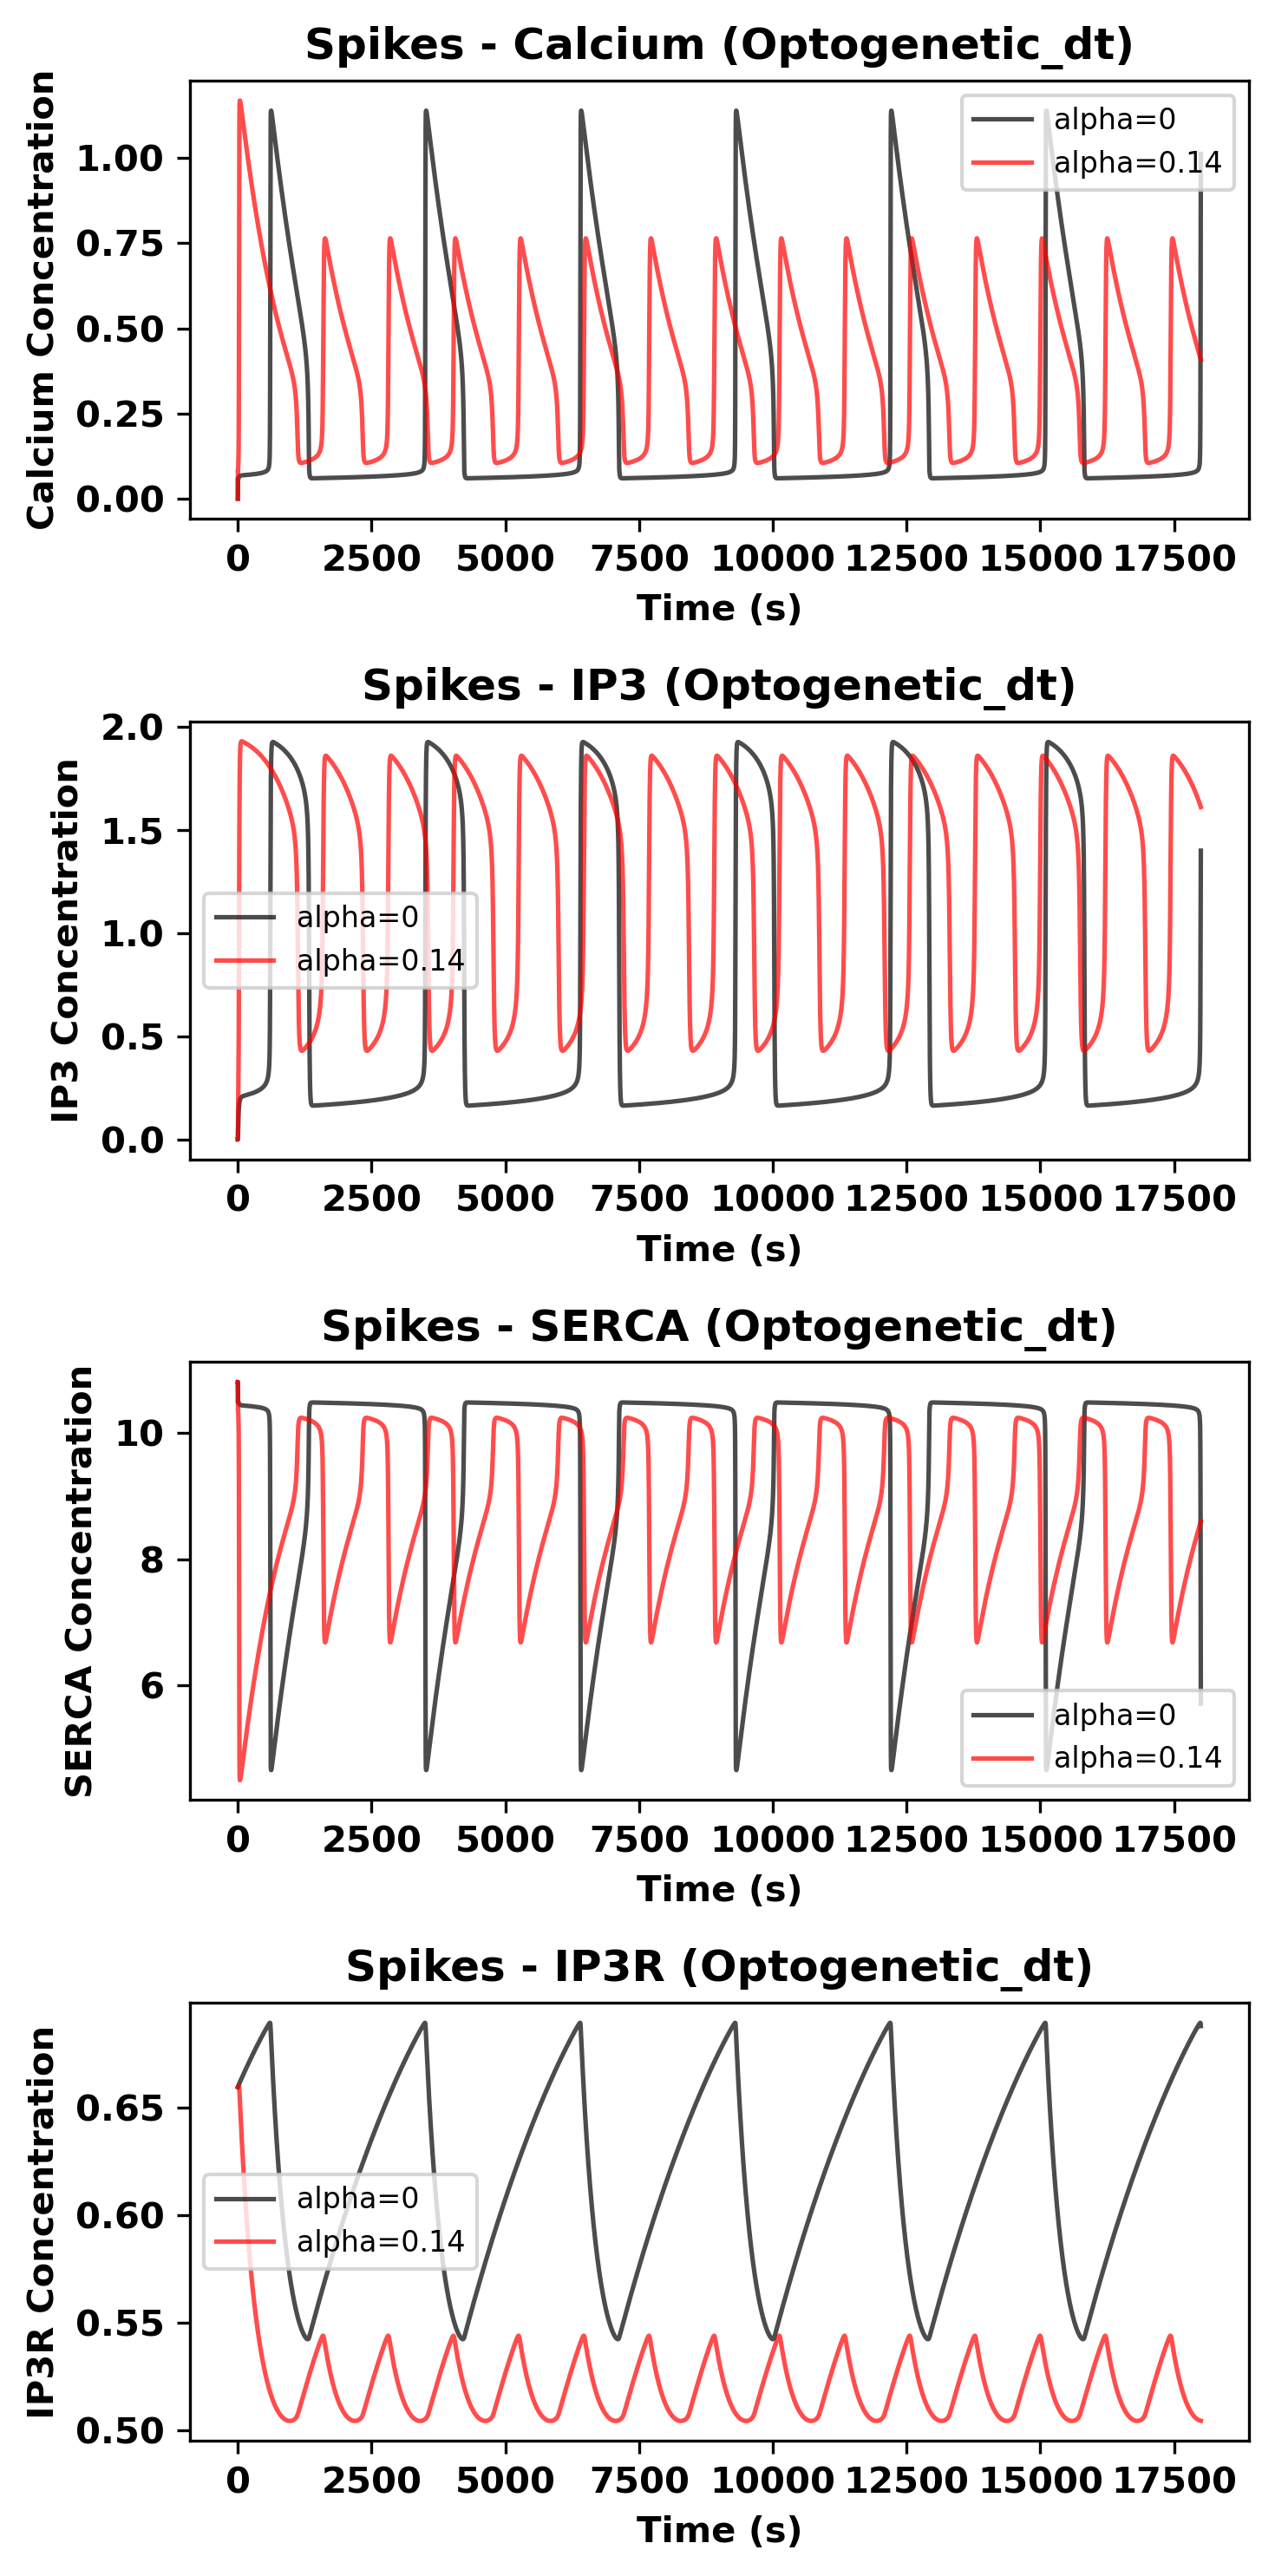

In [9]:
# Plot calcium, IP3, SERCA, and IP3R dynamics for different alpha values (optogenetic_dt version)
state_labels = ['Calcium', 'IP3', 'SERCA', 'IP3R']
cell_indices = [77, 596]
custom_colors = ['black', 'red', 'blue', 'orange', 'green']


for cell_index in cell_indices:
    fig, axes = plt.subplots(4, 1, figsize=(5, 10), dpi=300)  # Adjusted for a single column

    for row, label in enumerate(state_labels):
        ax = axes[row]  # Get the current axis

        for i, alpha in enumerate(alpha_values):
            dynamics = simulations['Spikes'][i].disc_dynamics[cell_index, row, :]
            color = custom_colors[i % len(custom_colors)]  # Cycle through colors if more alpha values than colors
            ax.plot(dynamics, label=f'alpha={alpha}', alpha=0.7, color=color, linewidth=1.25)

        ax.set_title(f'Spikes - {label} (Optogenetic_dt)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=10, fontweight='bold')  # Bold X-axis label
        ax.set_ylabel(f'{label} Concentration', fontsize=10, fontweight='bold')  # Bold Y-axis label

        # Make x and y ticks bold
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(10)

        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.png'), transparent=True)
    plt.show()


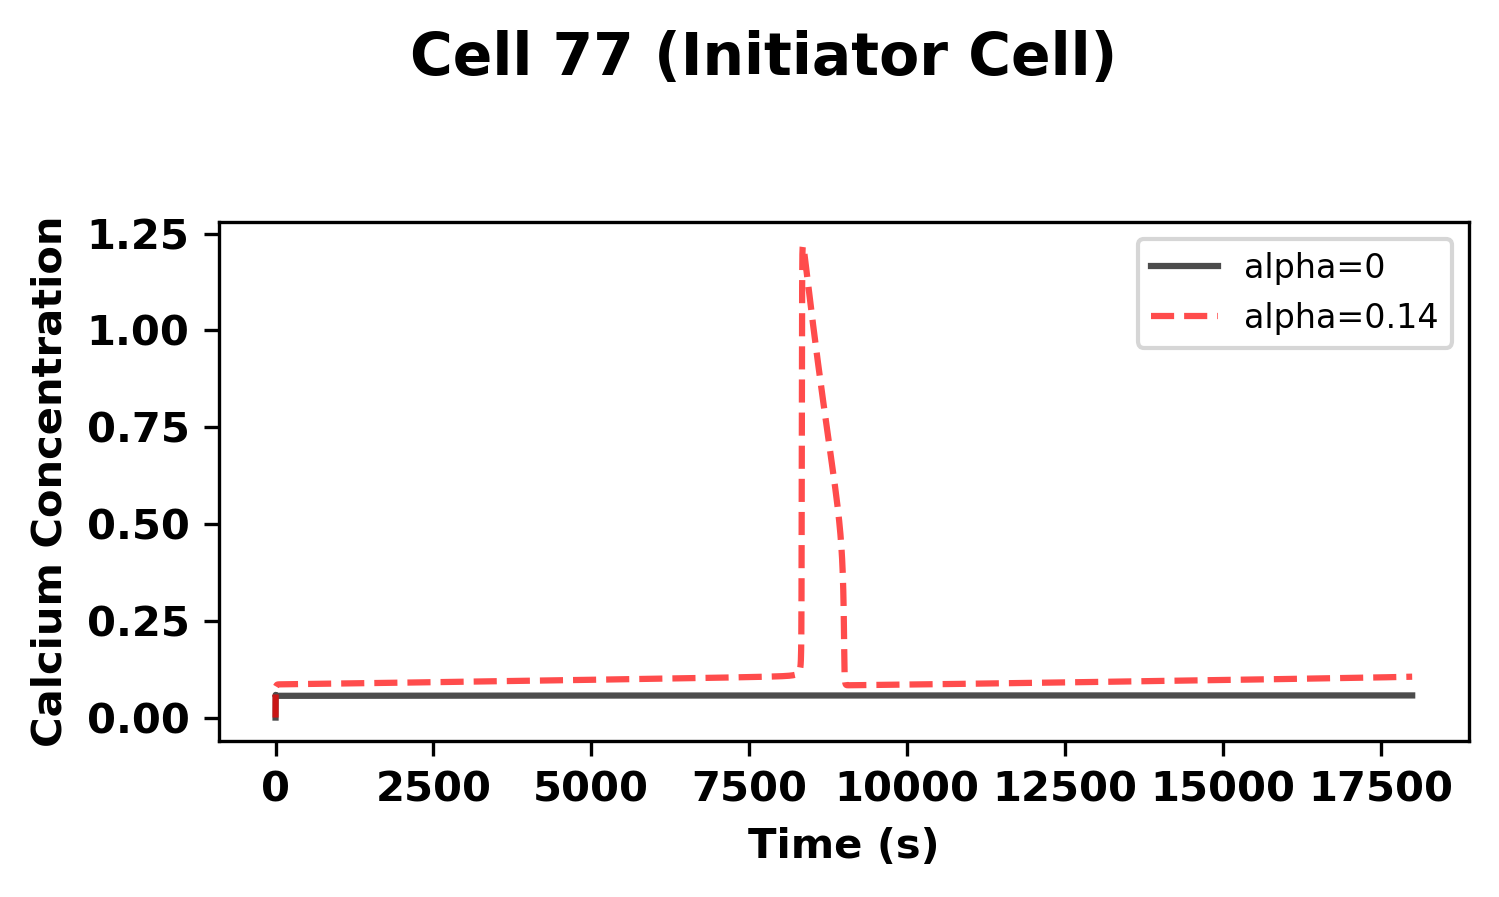

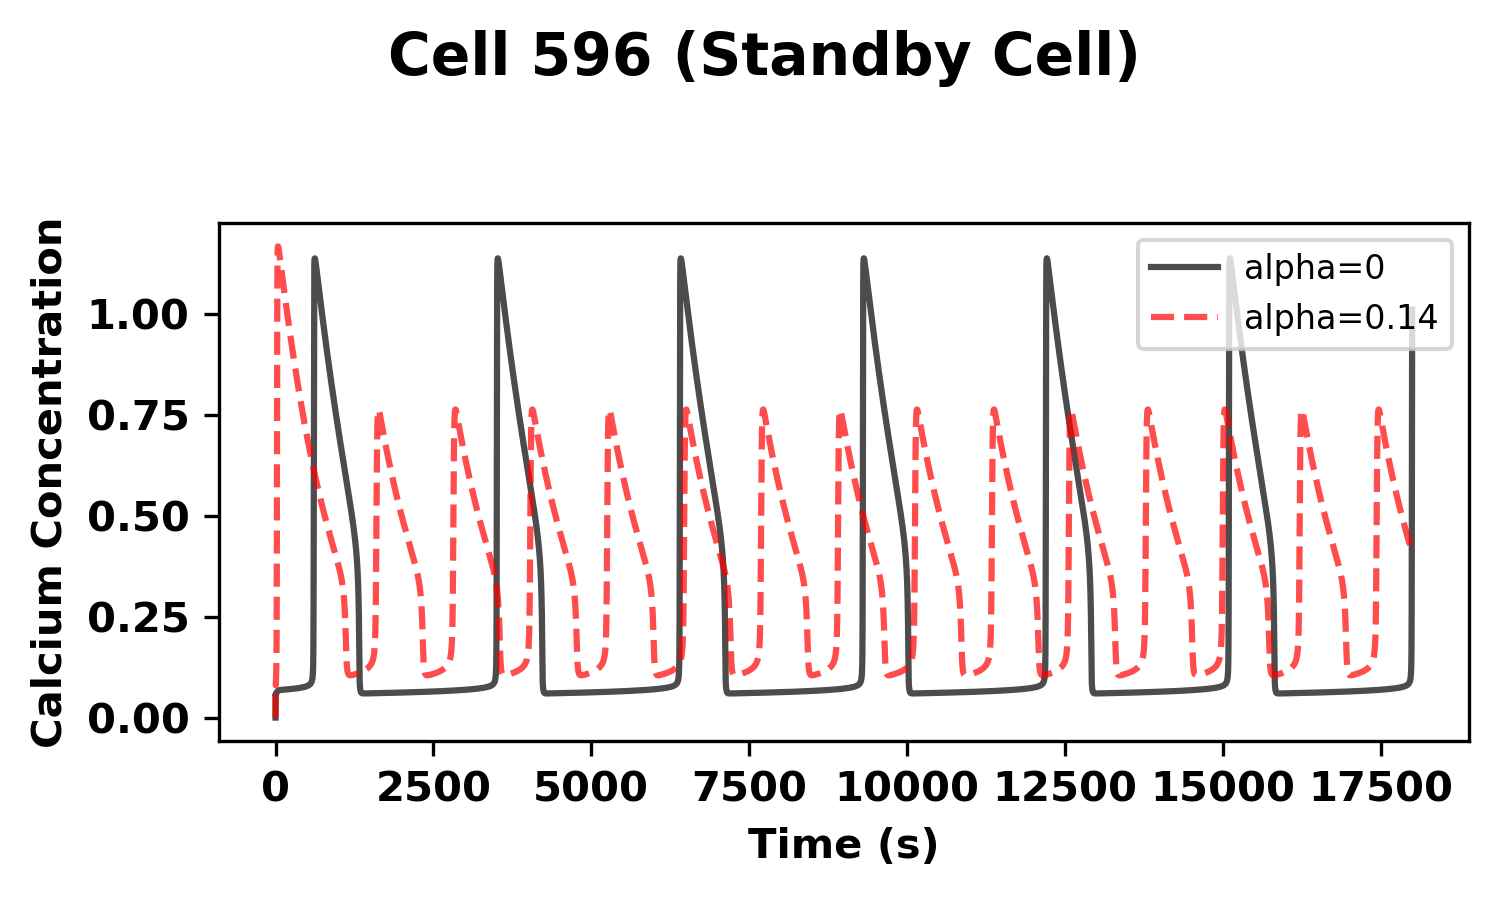

In [10]:
# Only plot calcium (state 0), remove subplot titles, and add custom figure titles with cell indices and cell type info

cell_indices = [77, 596]
custom_colors = ['black', 'red', 'blue', 'orange', 'green']

for idx, cell_index in enumerate(cell_indices):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
    for i, alpha in enumerate(alpha_values):
        dynamics = simulations['Spikes'][i].disc_dynamics[cell_index, 0, :]
        color = custom_colors[i % len(custom_colors)]
        # Use a different marker and linestyle for each line
        linestyle = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i % 5]
        ax.plot(
            dynamics,
            label=f'alpha={alpha}',
            alpha=0.7,
            color=color,
            linewidth=1.5,
            linestyle=linestyle
        )

    ax.set_xlabel('Time (s)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Calcium Concentration', fontsize=10, fontweight='bold')

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(10)

    ax.legend(fontsize=8)

    # Custom figure title
    if idx == 0:
        fig_title = f'Cell {cell_index} (Initiator Cell)'
    else:
        fig_title = f'Cell {cell_index} (Standby Cell)'
    plt.suptitle(fig_title, fontsize=14, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(os.path.join(sim_folder_path, f'Spikes_Calcium_Cell_{cell_index}.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, f'Spikes_Calcium_Cell_{cell_index}.png'), transparent=True)
    plt.show()

# Addressing reviewer comments, sensitivity analysis of alpha and D_p on number of spiking cells.

In [12]:
import pandas as pd
import gc

# Define ranges for alpha and D_p
alpha_values = np.linspace(0, 0.1, 25)  # 25 values from 0 to 0.1
Dp_values = np.linspace(0, 0.01, 25)  # 25 values from 0 to 0.01

# Prepare results DataFrame
results_df = pd.DataFrame(columns=['alpha', 'D_p', 'fraction_spiking_gap'])

print("Starting simulations for varying alpha and D_p values...")
for alpha in alpha_values:
    print(f"Simulating for alpha: {alpha:.4f}")
    for D_p in Dp_values:
        print(f"Simulating for D_p: {D_p:.4f}")
        sim_params = sim_params_Spikes.copy()
        sim_params['alpha'] = alpha
        sim_params['D_p'] = D_p

        sim = Pouch(params=sim_params, size='small', sim_number=12345, save=False, saveName=f'alpha_{alpha:.4f}_Dp_{D_p:.4f}')
        sim.simulate_optogenetic_dt()

        # Fraction of spiking cells (gap case)
        num_spiking = sim.count_spiking_cells(threshold=0.5)
        fraction_spiking = num_spiking / sim.n_cells

        # Save results_df to CSV at every new alpha value
        if D_p == Dp_values[0]:
            # First D_p for this alpha, write (overwrite) CSV
            results_df.to_csv(os.path.join(sim_folder_path, 'results_alpha_Dp_spiking.csv'), index=False, mode='w')
        else:
            # Append for subsequent D_p values
            results_df.to_csv(os.path.join(sim_folder_path, 'results_alpha_Dp_spiking.csv'), index=False, mode='a', header=False)

        results_df = pd.concat([
            results_df,
            pd.DataFrame({'alpha': [alpha], 'D_p': [D_p], 'fraction_spiking_gap': [fraction_spiking]})
        ], ignore_index=True)

        del sim
        gc.collect()


Starting simulations for varying alpha and D_p values...
Simulating for alpha: 0.0000
Simulating for D_p: 0.0000


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_83718/3061824735.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


Simulating for D_p: 0.0004
Simulating for D_p: 0.0008
Simulating for D_p: 0.0013
Simulating for D_p: 0.0017
Simulating for D_p: 0.0021
Simulating for D_p: 0.0025
Simulating for D_p: 0.0029
Simulating for D_p: 0.0033
Simulating for D_p: 0.0038
Simulating for D_p: 0.0042
Simulating for D_p: 0.0046
Simulating for D_p: 0.0050
Simulating for D_p: 0.0054
Simulating for D_p: 0.0058
Simulating for D_p: 0.0063
Simulating for D_p: 0.0067
Simulating for D_p: 0.0071
Simulating for D_p: 0.0075
Simulating for D_p: 0.0079
Simulating for D_p: 0.0083
Simulating for D_p: 0.0088
Simulating for D_p: 0.0092
Simulating for D_p: 0.0096
Simulating for D_p: 0.0100
Simulating for alpha: 0.0042
Simulating for D_p: 0.0000
Simulating for D_p: 0.0004
Simulating for D_p: 0.0008
Simulating for D_p: 0.0013
Simulating for D_p: 0.0017
Simulating for D_p: 0.0021
Simulating for D_p: 0.0025
Simulating for D_p: 0.0029
Simulating for D_p: 0.0033
Simulating for D_p: 0.0038
Simulating for D_p: 0.0042
Simulating for D_p: 0.0046

KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6), dpi=200)



# # Define a consistent color order


# # Plotting with specified colors, markers, and increased linewidth

# ax.plot(results_df['alpha'], results_df['fraction_initiators_no_gap'], label='No Gap', color=custom_colors[1], marker='s', alpha=0.7, linewidth=2, markersize=6)

# ax.set_xscale('log')
# # ax.set_title('Initiator Fractions vs Alpha', fontsize=16, fontweight='bold')
# ax.set_xlabel('Log(Optogenetic Scaling Coefficient)', fontsize=14, fontweight='bold')
# ax.set_ylabel('Fraction of Initiator Cells', fontsize=14, fontweight='bold')

# # Make x and y ticks bold with larger fontsize
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontweight('bold')
#     label.set_fontsize(12)

# # ax.legend(fontsize=12)
# # ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
# # Set the x-axis limits
# ax.set_xlim([min(results_df['alpha']), max(results_df['alpha'])])

# # Add vertical line at alpha = 0.04 and label it "100 lux"
# ax.axvline(x=0.14, color='gray', linestyle='--', linewidth=2)
# ax.text(0.1425, ax.get_ylim()[1]*0.75, '100 lux', color='gray', fontsize=14, fontweight='bold', rotation=0, ha='left', va='top')

# ax.axvline(x=0.34, color='gray', linestyle='--', linewidth=2)
# ax.text(0.3425, ax.get_ylim()[1]*0.75, 'Saturation', color='gray', fontsize=14, fontweight='bold', rotation=0, ha='left', va='top')

# plt.tight_layout()

# # Save the figure with transparent background
# plt.savefig(os.path.join(sim_folder_path, 'Initiator_Fractions_vs_Alpha_small.svg'), transparent=True)
# plt.savefig(os.path.join(sim_folder_path, 'Initiator_Fractions_vs_Alpha_small.png'), transparent=True)

# plt.show()
